In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
sns.set_theme()

In [ ]:
# Leer datos unzippeados
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/ajuste.txt", header=None, sep=" ", names=["x", "y"])
df_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/validacion.txt", header=None, sep=" ", names=["x", "y"])

In [ ]:
df_train.head()

,x,y
0,-1.000000,-1.333939
1,-0.959596,-2.309196
2,-0.919192,-2.033500
3,-0.878788,-1.298408
4,-0.838384,-0.297731


In [ ]:
df_train.shape, df_val.shape

((50, 2), (50, 2))

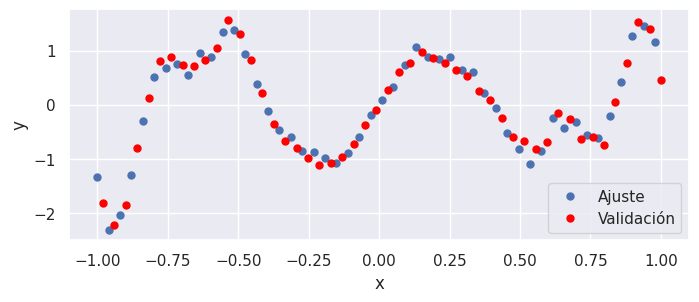

In [ ]:
# Scatterplot
plt.figure(figsize=(8, 3))
plt.plot(df_train.x, df_train.y, "o", markersize=5)
plt.plot(df_val.x, df_val.y, "o", markersize=5, color="red")
plt.legend(["Ajuste", "Validación"])
plt.xlabel("x")
plt.ylabel("y")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/scatterplot.pdf", bbox_inches='tight')
plt.show()

In [ ]:
def cuadrados_minimos(X, y):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    Sinv = np.diag(1/S)
    beta_pred = Vt.T @ Sinv @ U.T @ y
    return beta_pred

def cuadrados_minimos_ridge(X, y, l):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    D = np.diag(S / (S**2 + l))
    beta_pred = Vt.T @ D @ U.T @ y
    return beta_pred

def predict(X, betas):
    y_pred = (betas.T @ X.T).T
    return y_pred

def ecm(y, y_pred):
    return np.mean((y_pred-y)**2)

In [ ]:
# Experimento
grados = np.arange(1, 49+1)
lambdas = np.logspace(-7, 2, 100, base=10)
results = []

for grado in grados:
    for l in lambdas:
        X_train = np.polynomial.legendre.legvander(df_train.x, grado)
        X_val = np.polynomial.legendre.legvander(df_val.x, grado)
        betas = cuadrados_minimos_ridge(X_train, df_train.y, l)
        y_pred = predict(X_val, betas)
        error = ecm(df_val.y, y_pred)
        results.append((grado, l, error))

In [ ]:
df_results = pd.DataFrame(results, columns=["grado", "lambda", "ecm"])
df_results.shape

(4900, 3)

In [ ]:
df_results.sort_values("ecm").head()


,grado,lambda,ecm
3158,32,0.018738,0.013066
3159,32,0.023101,0.013085
3262,33,0.043288,0.013187
3160,32,0.028480,0.013213
3157,32,0.015199,0.013214


In [ ]:
df_results.sort_values("ecm", ascending=False).head()


,grado,lambda,ecm
3100,32,1.000000e-07,29483.014960
3101,32,1.232847e-07,23559.006781
3000,31,1.000000e-07,21148.039247
3001,31,1.232847e-07,19344.837446
3102,32,1.519911e-07,18424.084668


In [ ]:
grado_best = int(df_results.sort_values("ecm").iloc[0].grado)
lambda_best = df_results.sort_values("ecm").iloc[0]["lambda"]
ecm_best = df_results.sort_values("ecm").iloc[0].ecm
idx_grados_best = np.where(grados == grado_best)[0][0]
idx_lambdas_best = np.where(lambdas == lambda_best)[0][0]
print("Mejor lambda:", lambda_best, idx_lambdas_best, "\nMejor grado:", grado_best, idx_grados_best)

grado_worst = int(df_results.sort_values("ecm").iloc[-1].grado)
lambda_worst = df_results.sort_values("ecm").iloc[-1]["lambda"]
ecm_worst = df_results.sort_values("ecm").iloc[-1].ecm
idx_grados_worst = np.where(grados == grado_worst)[0][0]
idx_lambdas_worst = np.where(lambdas == lambda_worst)[0][0]
print("Peor lambda:", lambda_worst, idx_lambdas_worst, "\nPeor grado:", grado_worst, idx_grados_worst)

Mejor lambda: 0.01873817422860383 58 
Mejor grado: 32 31
Peor lambda: 1e-07 0 
Peor grado: 32 31


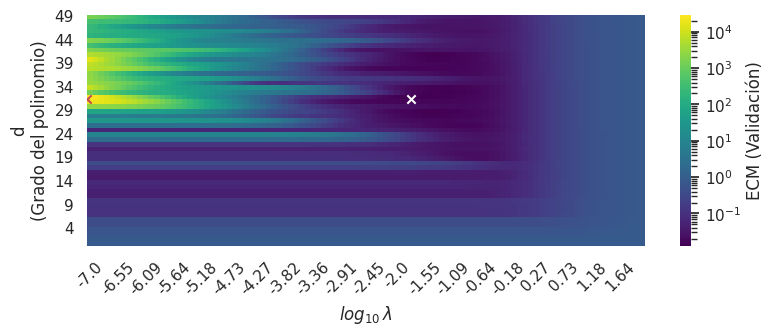

In [ ]:
# Heatmap
df_results_pivot = df_results.pivot(index="grado", columns="lambda", values="ecm").iloc[::-1]
df_results_pivot.columns = np.round(np.log10(df_results_pivot.columns), 2)

plt.figure(figsize=(9, 3))
heatmap = sns.heatmap(df_results_pivot, cmap="viridis", xticklabels=5, yticklabels=5, linewidths=.0, norm=LogNorm())
plt.xlabel("$log_{10}\,\lambda$")
plt.ylabel("d\n(Grado del polinomio)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.scatter([idx_lambdas_best], [len(grados) - idx_grados_best], marker="x", color="w")
plt.scatter([idx_lambdas_worst], [len(grados) - idx_grados_worst], marker="x", color="r")
heatmap.collections[0].colorbar.set_label('ECM (Validación)')

plt.savefig("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/heatmap.pdf", bbox_inches='tight')
plt.show()

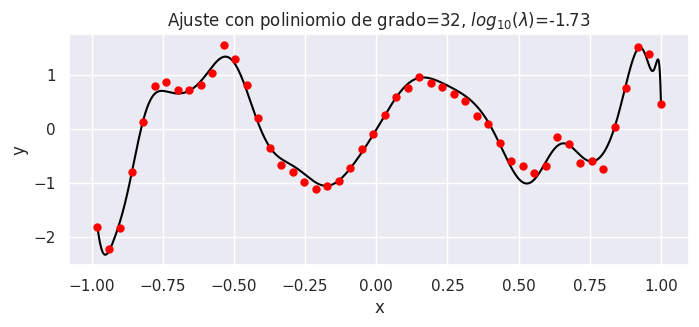

log10 ECM: -1.8838638069872637
Coeficiente más grande: 1.7614759920930827 5


In [ ]:
# Valores ajustados para el mejor modelo
X_train = np.polynomial.legendre.legvander(df_train.x, grado_best)
betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_best)
xs = np.linspace(df_val.x.min(), df_val.x.max(), 1000) # grilla de xs
X = np.polynomial.legendre.legvander(xs, grado_best)
y_pred = predict(X, betas)

plt.figure(figsize=(8, 3))
plt.plot(xs, y_pred, color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Ajuste con poliniomio de grado={grado_best}, $log_{{10}}$($\lambda$)={np.log10(lambda_best):.2f}")
plt.plot(df_val.x, df_val.y, "o", markersize=5, color="red")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/ajuste_mejor.pdf", bbox_inches='tight')

xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()

plt.show()
print("log10 ECM:", np.log10(ecm_best))
print("Coeficiente más grande:", max(betas), betas.argmax())

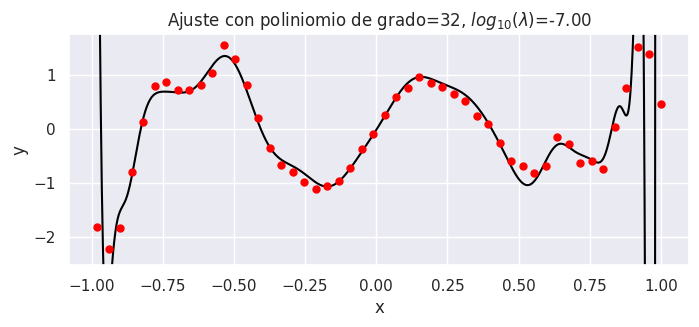

log10 ECM: 4.469571892803935
Coeficiente más grande: 70.3790564189489 14


In [ ]:
# Idem peor modelo
X_train = np.polynomial.legendre.legvander(df_train.x, grado_worst)
betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_worst)
xs = np.linspace(df_val.x.min(), df_val.x.max(), 1000) # grilla de xs
X = np.polynomial.legendre.legvander(xs, grado_worst)
y_pred = predict(X, betas)

plt.figure(figsize=(8, 3))
plt.plot(xs, y_pred, color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(xlim)
plt.ylim(ylim)
plt.title(f"Ajuste con poliniomio de grado={grado_worst}, $log_{{10}}$($\lambda$)={np.log10(lambda_worst):.2f}")
plt.plot(df_val.x, df_val.y, "o", markersize=5, color="red")

# plt.savefig("ajuste_peor.pdf", bbox_inches='tight')

plt.show()
print("log10 ECM:", np.log10(ecm_worst))
print("Coeficiente más grande:", max(betas), betas.argmax())

Observaciones notables interesantes previas a más inspección:
1. Bandeo horizontal: para un mismo grado de ajuste hay mejora gradual en el poder predictivo con incremento de lambda, hasta cierto punto. Esto se debe a la reducción del overfitting.
2. Independencia del grado con lambda suficientemente alto: el ECM es aproximadamente constante, sin importar el grado polinomial, si lambda es grande. Asumo que esto es porque todos los polinomios se "planchan" a 0, el error es dominado por la regularización.
3. Independencia de lambda con grado suficientemente bajo: el ECM es aproximadamente constante, sin importar el valor de lambda, si el grado es bajo. Asumo que esto es porque para grado suficientemente bajo es imposible un buen ajuste de los datos.
4. La región de error mínimo balancea grado y lambda (esto es más bien teórico/surge de ver la gran calidad del mejor ajuste, no vamos a mostrarlo con un gráfico particular).
5. La región de error máximo es la de overfitting: grado polinomial alto y
lambda bajo. Sería particularmente interesante ver como se vé el grado 32 con el lambda mínimo.

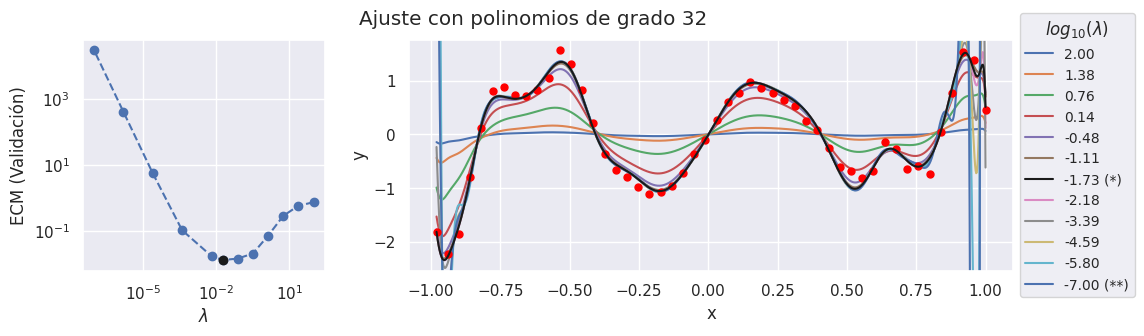

In [ ]:
# Bandeo horizontal (1), error máximo y overfitting (5), independencia del grado con lambda alto (2), grado = 32
n = 7
lambda_values = np.logspace(np.log10(lambdas[idx_lambdas_best]), np.log10(lambdas[-1]), n, base=10)
X_train = np.polynomial.legendre.legvander(df_train.x, 32)
xs = np.linspace(df_val.x.min(), df_val.x.max(), 1000) # grilla de xs
X = np.polynomial.legendre.legvander(xs, 32)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), width_ratios=[0.4,1])
l = []
errores = []

plt.suptitle("Ajuste con polinomios de grado 32")
legend = []
for i, lambda_val in enumerate(lambda_values[::-1]):
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X, betas)
    if i == n-1:
        plt.plot(xs, y_pred, c="k", zorder=50)
        legend += [f"{np.log10(lambda_val):.2f} (*)"]
    else:
        plt.plot(xs, y_pred)
        legend += [f"{np.log10(lambda_val):.2f}"]

    X_val = np.polynomial.legendre.legvander(df_val.x, 32)
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X_val, betas)
    l.append(lambda_val)
    errores.append(ecm(df_val.y, y_pred))

n2 = 5
lambda_values = np.logspace(np.log10(lambdas[0]), np.log10(lambdas[idx_lambdas_best-5]), n2, base=10)
for i, lambda_val in enumerate(lambda_values[::-1]):
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X, betas)
    plt.plot(xs, y_pred)

    X_val = np.polynomial.legendre.legvander(df_val.x, 32)
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X_val, betas)
    l.append(lambda_val)
    errores.append(ecm(df_val.y, y_pred))

    if i == n2-1:
        legend += [f"{np.log10(lambda_val):.2f} (**)"]
    else:
        legend += [f"{np.log10(lambda_val):.2f}"]

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(legend, loc="center left", bbox_to_anchor=(1, 0.5), title="$log_{{10}}$($\lambda$)", fontsize='small')
plt.plot(df_val.x, df_val.y, "o", markersize=5, color="red")

ax1.plot(l, errores, "--o")
ax1.scatter([l[n-1]], [errores[n-1]], c="k", zorder=50)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("ECM (Validación)")
xloglim = ax1.get_xlim()
yloglim = ax1.get_ylim()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/ajuste_banda.pdf", bbox_inches='tight')

plt.show()

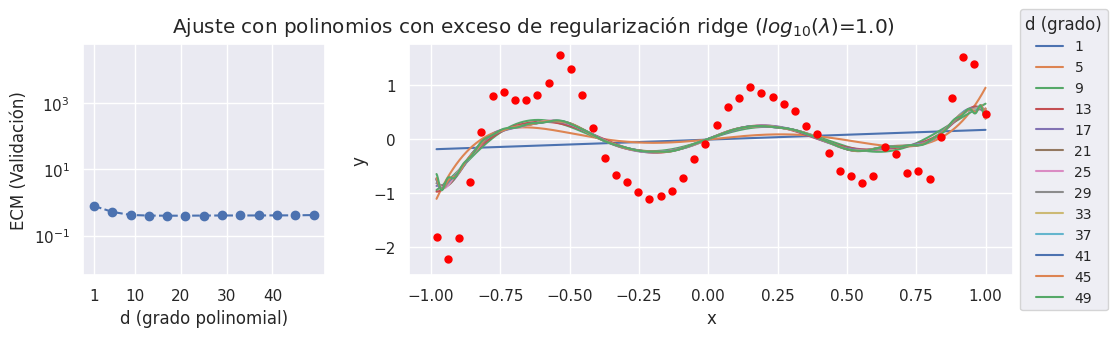

In [ ]:
# Independencia del grado con lambda alto (2)
n = 9
skip=4
lambda_val = 10
xs = np.linspace(df_val.x.min(), df_val.x.max(), 1000) # grilla de xs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), width_ratios=[0.4,1])
errores = []

plt.suptitle(f"Ajuste con polinomios con exceso de regularización ridge ($log_{{10}}$($\lambda$)={round(np.log10(lambda_val), 2)})")
legend = []
for grado in grados[::skip]:
    X_train = np.polynomial.legendre.legvander(df_train.x, grado)
    X = np.polynomial.legendre.legvander(xs, grado)
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X, betas)
    plt.plot(xs, y_pred)
    legend += [grado]

    X_val = np.polynomial.legendre.legvander(df_val.x, grado)
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X_val, betas)
    errores.append(ecm(df_val.y, y_pred))

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(legend, loc="center left", bbox_to_anchor=(1, 0.5), title="d (grado)", fontsize='small')
plt.plot(df_val.x, df_val.y, "o", markersize=5, color="red")

ax1.plot(grados[::skip], errores, "--o")
ax1.set_yscale("log")
ax1.set_xlabel("d (grado polinomial)")
ax1.set_ylabel("ECM (Validación)")
ax1.set_xticks([1,10,20,30,40])
ax1.set_ylim(yloglim)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/ajuste_exceso_ridge.pdf", bbox_inches='tight')

plt.show()

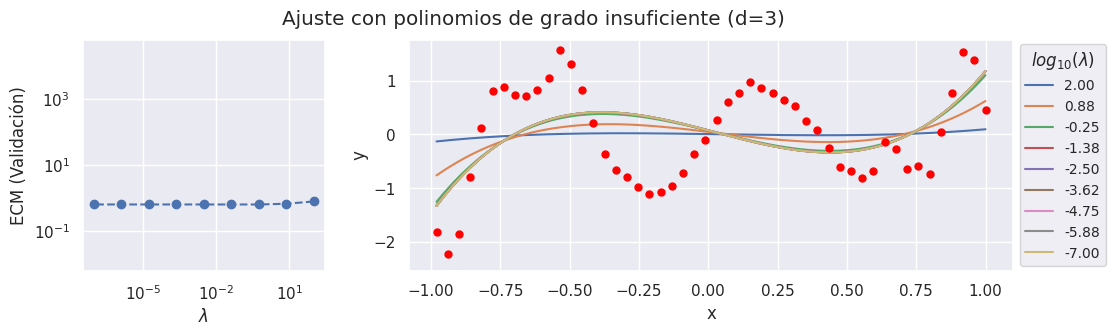

In [ ]:
# Independencia de lambda con grado insuficiente (3)
n = 9
grado = 3
lambda_values = np.logspace(-7, 2, n, base=10)
X_train = np.polynomial.legendre.legvander(df_train.x, grado)
xs = np.linspace(df_val.x.min(), df_val.x.max(), 1000) # grilla de xs
X = np.polynomial.legendre.legvander(xs, grado)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), width_ratios=[0.4,1])
errores = []

plt.suptitle(f"Ajuste con polinomios de grado insuficiente (d={grado})")
legend = []
for lambda_val in lambda_values[::-1]:
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X, betas)
    plt.plot(xs, y_pred)
    legend += [f"{np.log10(lambda_val):.2f}"]

    X_val = np.polynomial.legendre.legvander(df_val.x, grado)
    betas = cuadrados_minimos_ridge(X_train, df_train.y, lambda_val)
    y_pred = predict(X_val, betas)
    errores.append(ecm(df_val.y, y_pred))

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(legend, loc="center left", bbox_to_anchor=(1, 0.5), title="$log_{{10}}$($\lambda$)", fontsize='small')
plt.plot(df_val.x, df_val.y, "o", markersize=5, color="red")

ax1.plot(lambda_values[::-1], errores, "--o")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("ECM (Validación)")
ax1.set_ylim(yloglim)

plt.savefig("/content/drive/MyDrive/Colab Notebooks/tp3 metnum/ajuste_grado_bajo.pdf", bbox_inches='tight')

plt.show()